This notebook demonstrates how to generate images of handwritten digits using [tf.keras](https://www.tensorflow.org/programmers_guide/keras) and [eager execution](https://www.tensorflow.org/programmers_guide/eager).

It was orginally made for DCGANs and has been repurposed to show the difference between saturating and non-saturating loss functions for basic GANs.

This model takes about ~15-25 seconds per epoch (using tf.contrib.eager.defun to create graph functions) to train on a single Tesla K80 on Colab, as of July 2018.

Below is the output generated after training the (original DCGAN) generator and discriminator models for 150 epochs.

![sample output](https://tensorflow.org/images/gan/dcgan.gif)

In [0]:
# to generate gifs
!pip install imageio

    100% |████████████████████████████████| 3.3MB 8.9MB/s 
  Running setup.py bdist_wheel for imageio ... - \ | / done
  Stored in directory: /root/.cache/pip/wheels/e0/43/31/605de9372ceaf657f152d3d5e82f42cf265d81db8bbe63cde1
Successfully built imageio


## Import TensorFlow and enable eager execution

In [0]:
from __future__ import absolute_import, division, print_function

# Import TensorFlow >= 1.10 and enable eager execution
import tensorflow as tf
tf.enable_eager_execution()
from keras import initializers

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
from IPython import display

Using TensorFlow backend.


## Load the dataset

We are going to use the MNIST dataset to train the generator and the discriminator. The generator will then generate handwritten digits.

In [0]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [0]:
train_images = train_images.reshape(train_images.shape[0], 784).astype('float32')
# We are normalizing the images to the range of [-1, 1]
train_images = (train_images - 127.5) / 127.5

In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
NOISE_DIM = 100

## Use tf.data to create batches and shuffle the dataset

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Stuff [Max](github.com/maxisawesome) wrote

## Write the generator and discriminator models

* **Generator** 
  * It is responsible for **creating convincing images that fool the discriminator**.
  * We're just demonstrating the loss functions, so the GAN is a pretty simple neural network consisting of only fully connected layers. 
    * As such, we've reshaped the (28, 28) image into a (784) vector to fit the first fullly connected layer.
  * We use **leaky relu** activation except for the **last layer** which uses **tanh** activation. 
    * We use leaky relu because it gives good results. We use tanh because it give outputs between -1 and 1.
  
* **Discriminator**
  * **The discriminator is responsible for classifying the fake images from the real images.**
  * In other words, the discriminator is given generated images (from the generator) and the real MNIST images. The job of the discriminator is to classify these images into fake (generated) and real (MNIST images).
  * The discriminator is also constructed of only fully connected layers. It aditionally uses dropout to help with generalization. 
    * Note that while while the layers of our generator and discriminators are mirrored (Generator: 100-->128-->256-->512-->784, Discriminator:  784-->512-->256-->128-->1), this is not a requirement in GANs.
  * **The generator should be good enough to fool the discriminator that the generated images are real**.

In [0]:
class Generator(tf.keras.Model):
  def __init__(self):
    super(Generator, self).__init__()
    self.fc1 = tf.keras.layers.Dense(128, input_dim=NOISE_DIM)
    self.fc2 = tf.keras.layers.Dense(256)
    self.fc3 = tf.keras.layers.Dense(512)
    self.out = tf.keras.layers.Dense(784)
    
    
  def call(self, x, training=True):
    x = tf.nn.relu(self.fc1(x))
    x = tf.nn.relu(self.fc2(x))
    x = tf.nn.relu(self.fc3(x))
    x = tf.nn.tanh(self.out(x))
      
    return x

In [0]:
class Discriminator(tf.keras.Model):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.fc1 = tf.keras.layers.Dense(512, input_shape=(784,))
    self.fc2 = tf.keras.layers.Dense(256)
    self.fc3 = tf.keras.layers.Dense(128)
    self.out = tf.keras.layers.Dense(1)
    self.dropout = tf.keras.layers.Dropout(0.3)

  def call(self, x, training=True):
    x = tf.nn.leaky_relu(self.fc1(x))
    x = self.dropout(x, training=training)
    x = tf.nn.leaky_relu(self.fc2(x))
    x = self.dropout(x, training=training)
    x = tf.nn.leaky_relu(self.fc3(x))
    x = self.dropout(x, training=training)
    x = tf.nn.sigmoid(self.out(x))
    return x

In [0]:
# Defun gives 10 secs/epoch performance boost
generator.call = tf.contrib.eager.defun(generator.call)
discriminator.call = tf.contrib.eager.defun(discriminator.call)

## Define the loss functions and the optimizer
Let's review some of the orginal GAN paper's section on GAN losses. "D" refers to the Discriminator network, "G" refers to the generator network, "z" is a vector of noise, and "x" in a real image:

>We train D to maximize the probability of assigning the correct label to both training examples and samples from G. We simultaneously train G to minimize $\log(1 − D(G(z)))$. In other words, D and G play the following two-player minimax game with value function $V (G, D)$:

>> $\begin{equation}
\min_G \max_D V(D, G)= \mathbb{E}_{x\sim p_{data}(x)}[\log D(x)]+ \mathbb{E}_{z\sim p_z(z)}[\log(1 - D(G(z)))]
\end{equation}$
 
>In practice,  the previous equation may not provide sufficient gradient for G to learn well. Early in learning, when G is poor, D can reject samples with high confidence because they are clearly different from the training data. In this case, $\log(1 − D(G(z)))$ saturates. Rather than training G to minimize $\log(1 − D(G(z)))$ we can train G to maximize $\log D(G(z))$. This objective function results in the same fixed point of the dynamics of G and D but provides much stronger gradients early in learning.

Great, we have a definition of our overal goal in a GAN (the long equation), and definitions of the loss function for G. The next page of the paper defines the explicit loss functions over batches. D(x) returns its probability that x is a real image. Intuitively, if x is a real image and z is a noise vector, we want D(x) to be high and D(G(z)) to be low.

We update the discriminator by ascending its stochastic gradient:
$\begin{equation}
\nabla_{\mathbf\theta_d} \frac{1}{m}\sum\limits_{i=1}^m [\log(D(x^{(i)}))-log(1-D(G(z^{(i)})))]
\end{equation}$

We update the generator by descending its stochastic gradient:
$\begin{equation}
\nabla_{\mathbf\theta_g} \frac{1}{m}\sum\limits_{i=1}^m \log(1-D(G(z^{(i)})))
\end{equation}$

In these equations, $m$ is the size of the minibatch. Thus, there is a minibatch of $m$ noise samples from the noise prior as well as $m$ examples from the training distribution. We ascend the discriminator's gradient and descend the generator's gradient in a way that is consistent with the minimax game defined before.  

* **Discriminator loss**
  * The discriminator loss function takes 2 inputs; **real_output, generated_output**
    * They are both outputs of the _discriminator_, and thus probability vectors. The first are the probabilities for a batch of real images being real, and the second are the probabilities a batch of fake images are real. 
  * Then the total_loss is the sum of real_loss and the generated_loss.
  * Tensorflow makes it easy to use batches - just pass the whole batch of probabilities into the tf.log function and use tf.reduce_mean.
  
* **Generator loss**
  * The generator has two options of loss function. They are named s_loss and ns_loss for saturating and non-saturating. 
    * In the non-saturating loss, we are no longer _minimizing_ a function, but _maximizing_ it instead. Tensorflow always tries to minimize things, and as such we return the negative of the value we want to maximize, becuase minimizing the negative of the value is the same as maximizing the positive of it.  
    
  

In [0]:
def discriminator_loss(real_output, generated_output):
    return -tf.reduce_mean(tf.log(real_output) + tf.log(1-generated_output))

In [0]:
def ns_generator_loss(generated_output):
    return -tf.reduce_mean(tf.log(generated_output))

In [4]:
# While the saturating loss appears in the orginal GAN paper, it is no longer used in practice.
# It is included for completeness.
def s_generator_loss(generated_output):
    return tf.reduce_mean(1-tf.log(generated_output))

When looking at graphs of the losses, if the ranges of values don't make sense, check the graph of the log function for help.

In [0]:
def plot_losses(dLosses, gLosses):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show

End of mostly what [Max](github.com/maxisawesome) wrote

In [0]:
discriminator_optimizer = tf.train.AdamOptimizer(1e-4)
generator_optimizer = tf.train.AdamOptimizer(1e-4)

## Checkpoints (Object-based saving)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Training

* We start by iterating over the dataset
* The generator is given **noise as an input** which when passed through the generator model will output a image looking like a handwritten digit
* The discriminator is given the **real MNIST images as well as the generated images (from the generator)**.
* Next, we calculate the generator and the discriminator loss.
* Then, we calculate the gradients of loss with respect to both the generator and the discriminator variables (inputs) and apply those to the optimizer.
* 50 Epochs will get us number-esque images, but 100 will result in much better pictures (but will take twice as long).

## Generate Images

* After training, its time to generate some images!
* We start by creating noise array as an input to the generator
* The generator will then convert the noise into handwritten images.
* Last step is to plot the predictions and **voila!**

In [0]:
EPOCHS = 100
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement of the gan.
random_vector_for_generation = tf.random_normal([num_examples_to_generate,
                                                 NOISE_DIM])

In [1]:
def generate_and_save_images(model, epoch, test_input, loss):
  # make sure the training parameter is set to False because we aren't training
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(tf.reshape(predictions[i], [28, 28]) * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
        
  plt.savefig(loss+'_image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [0]:
def train(dataset, epochs, noise_dim, s_loss=False): 
  d_losses = []
  g_losses = []
  loss_name = 's_loss' if s_loss else 'ns_loss'

  for epoch in range(epochs):
    start = time.time()
  
    for images in dataset:
      # generating noise from a uniform distribution
      # we use image.shape[0] and not BATCH_SIZE because the final batch is smaller 
      #   60000/256 is not an integer, so our last batch is smaller than 256.
      noise = tf.random_normal([images.shape[0], noise_dim])
      
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Run data or noise through the network
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        generated_output = discriminator(generated_images, training=True)
        
        # Get losses
        if s_loss:
          gen_loss = s_generator_loss(generated_output)
        else:
          gen_loss = ns_generator_loss(generated_output)
        disc_loss = discriminator_loss(real_output, generated_output)
        
        # Save the losses to plot them later
        g_losses.append(gen_loss)
        d_losses.append(disc_loss)
        
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.variables)
      
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.variables))
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.variables))

      
    if epoch % 1 == 0:
      # next line is handy line to make the output of the cell update cleanly
      display.clear_output(wait=True)
      generate_and_save_images(generator,
                               epoch + 1,
                               random_vector_for_generation,
                               loss_name)
      plot_losses(d_losses, g_losses)
      print ('Time taken for epoch {} is {} sec'.format(epoch + 1,
                                                      time.time()-start))
    
      min_til_done = ((time.time()-start)*(EPOCHS-epoch+1))/60
      print ('Approx min until completion %.2f min'%(min_til_done))
    
    # saving (checkpoint) the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    

    
  # generating after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           random_vector_for_generation,
                           loss_name)
  print("Done! %d epochs completed in %.2f minutes." %(EPOCHS, (time.time()-start)/60)

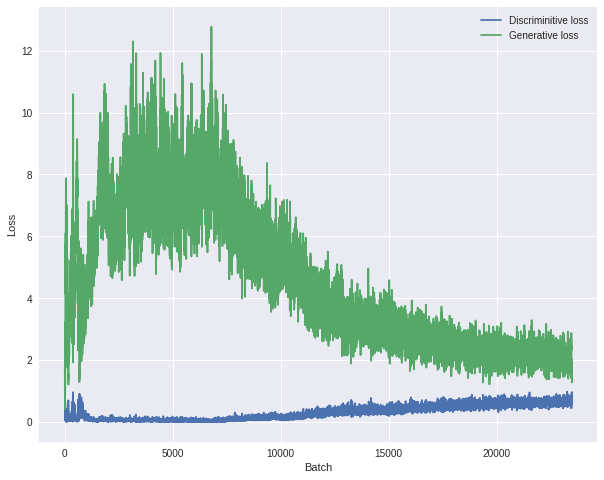

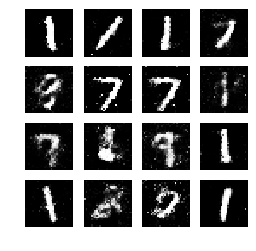

In [0]:
generator = Generator()
discriminator = Discriminator()
train(train_dataset, EPOCHS, NOISE_DIM, s_loss=False)

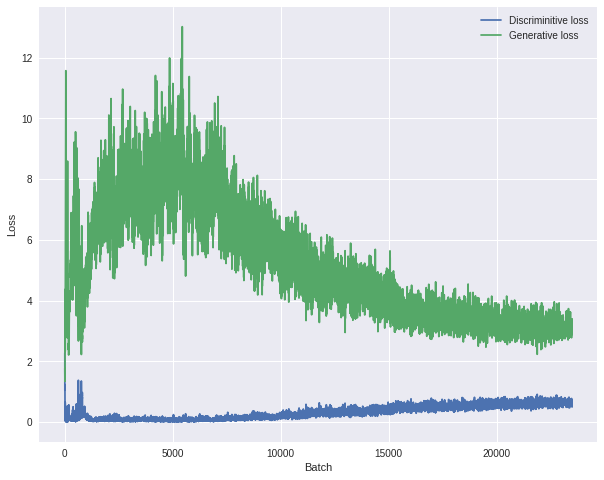

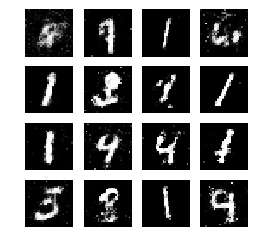

In [0]:
generator = Generator()
discriminator = Discriminator()
train(train_dataset, EPOCHS, NOISE_DIM, s_loss=True)

In [0]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Display an image using the epoch number

In [0]:
def display_image(epoch_no, loss):
    return PIL.Image.open(loss+'_image_at_epoch_{:04d}.png'.format(epoch_no))

In [0]:
display_image(EPOCHS)

## Generate a GIF of all the saved images.

In [3]:
# controls how fast the gif moves through the generated pictures
loss = "ns_loss"
#loss = "s_loss"
SPEED = 2
with imageio.get_writer('gan.gif', mode='I') as writer:
  filenames = glob.glob(loss+'_image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
    
# this is a hack to display the gif inside the notebook
os.system('cp gan.gif gan.gif.png')

NameError: name 'imageio' is not defined

In [0]:
display.Image(filename="gan.gif.png")

To downlod the animation from Colab uncomment the code below:

In [0]:
#from google.colab import files
#files.download('dcgan.gif')